In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [2]:
# import numpy as np
# import tensorflow as tf

# tf.compat.v1.disable_eager_execution()

# class Encodeur(tf.keras.layers.Layer):
#     def __init__(self, n_layers, d_model, num_heads, middle_units,
#                  max_seq_len, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
#         super(Encodeur, self).__init__(**kwargs)
#         self.n_layers = n_layers

#         self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
#         self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads, max_seq_len=max_seq_len,
#                                             middle_units=middle_units, epsilon=epsilon, 
#                                             dropout_rate=dropout_rate, training=training)
#                              for _ in range(n_layers)]

#     def call(self, inputs, **kwargs):
#         emb, masque = inputs
#         emb = self.embedding_position(emb)
#         for i in range(self.n_layers):
#             emb = self.couche_encode[i](emb, masque)
#         return emb

# class CoucheEncodeur(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
#         super(CoucheEncodeur, self).__init__(**kwargs)

#         self.mha = AttentionMultiTete(num_heads)
#         self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

#         self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
#         self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=epsilon)

#         self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
#         self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

#         self.training = training

#     def call(self, inputs, masque, **kwargs):
#         # Réseau d'attention multi-tête
#         sortie_att = self.mha([inputs, inputs, inputs, masque])
#         sortie_att = self.dropout1(sortie_att, training=self.training)
#         out1 = self.layernorm1(inputs + sortie_att)

#         # Réseau de transformation point à point
#         sortie_ffn = self.ffn(out1)
#         sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
#         out2 = self.layernorm2(out1 + sortie_ffn)

#         return out2

# def reseau_transformation_point_a_point(numUnits, middle_units):
#     return tf.keras.Sequential([
#         tf.keras.layers.Dense(middle_units, activation='relu'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.Dense(numUnits, activation='relu'),
#         tf.keras.layers.Dropout(0.1),
#         tf.keras.layers.LayerNormalization()
#     ])

# def attention_produit_scalaire_equilibre(q, k, v, masque):
#     matmul_qk = tf.matmul(q, k, transpose_b=True)
#     dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
#     attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
#     if masque is not None:
#         attention_logits_mis_a_echelle += (masque * -1e9)
#     poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
#     sortie = tf.matmul(poids_attention, v)
#     return sortie

# class AttentionMultiTete(tf.keras.layers.Layer):
#     def __init__(self, num_heads, **kwargs):
#         super(AttentionMultiTete, self).__init__(**kwargs)
#         self.num_heads = num_heads
#         self.attention_produit_scalaire = attention_produit_scalaire_equilibre

#     def separation_tetes(self, x, batch_size, profondeur):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs, **kwargs):
#         q, k, v, masque = inputs
#         batch_size = tf.shape(q)[0]
#         numUnits = q.get_shape().as_list()[-1]
#         profondeur = numUnits // self.num_heads

#         wq = tf.keras.layers.Dense(numUnits)
#         wk = tf.keras.layers.Dense(numUnits)
#         wv = tf.keras.layers.Dense(numUnits)
#         q = wq(q)
#         k = wk(k)
#         v = wv(v)

#         q = self.separation_tetes(q, batch_size, profondeur)
#         k = self.separation_tetes(k, batch_size, profondeur)
#         v = self.separation_tetes(v, batch_size, profondeur)

#         attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

#         attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

#         attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

#         dense = tf.keras.layers.Dense(numUnits)
#         sortie = dense(attention_concatenee)

#         return sortie

# def masque_remplissage(seq):
#     seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
#     return seq[:, np.newaxis, np.newaxis, :]

# class EncodagePosition(tf.keras.layers.Layer):
#     def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
#         super(EncodagePosition, self).__init__(**kwargs)
#         self.sequence_len = sequence_len
#         self.embedding_dim = embedding_dim

#     def call(self, inputs):
#         seq_len = tf.shape(inputs)[1]
#         if self.embedding_dim is None:
#             self.embedding_dim = int(inputs.shape[-1])

#         position_indices = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
#         dimension_indices = tf.range(self.embedding_dim, dtype=tf.float32)[tf.newaxis, :]

#         angle_rads = position_indices / tf.math.pow(10000.0, (2.0 * (dimension_indices // 2)) / tf.cast(self.embedding_dim, tf.float32))
#         sines = tf.math.sin(angle_rads[:, 0::2])
#         cosines = tf.math.cos(angle_rads[:, 1::2])
#         position_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

#         position_encoding = tf.cast(position_encoding, dtype=tf.float32)
#         return inputs + position_encoding

#     def compute_output_shape(self, input_shape):
#         return input_shape


In [24]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

class Encodeur(tf.keras.layers.Layer):
    def __init__(self, n_layers, d_model, num_heads, middle_units,
                 max_seq_len, epsilon=1e-7, dropout_rate=0.1, training=False, **kwargs):
        super(Encodeur, self).__init__(**kwargs)
        self.n_layers = n_layers

        self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
        self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads,max_seq_len=max_seq_len,
                                            middle_units=middle_units,
                                            epsilon=epsilon, dropout_rate=dropout_rate,
                                            training=training)
                             for _ in range(n_layers)]

    def call(self, inputs, **kwargs):
        emb, masque = inputs
        emb = self.embedding_position(emb)
        for i in range(self.n_layers):
            emb = self.couche_encode[i](emb, masque)

        return emb


# Couche d'encodage
class CoucheEncodeur(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-7, dropout_rate=0.1, training=False, **kwargs):
        super(CoucheEncodeur, self).__init__(**kwargs)

        self.mha = AttentionMultiTete(num_heads)
        # self.ffn = reseau_transformation_point_a_point(d_model + max_seq_len, middle_units) ## Erreur de Dimension
        self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

        self.layernorm1 = NormalisationCouche()
        self.layernorm2 = NormalisationCouche()

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.training = training

    def call(self, inputs, masque, **kwargs):
        # Réseau d'attention multi-tête
        sortie_att = self.mha([inputs, inputs, inputs, masque])
        sortie_att = self.dropout1(sortie_att, training=self.training)
        out1 = self.layernorm1(inputs + sortie_att)

        # Réseau de transformation point à point
        sortie_ffn = self.ffn(out1)
        sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
        out2 = self.layernorm2(out1 + sortie_ffn)  # Problème de dimension ici

        return out2

# Normalisation de couche
class NormalisationCouche(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-7, **kwargs):
        self.eps = epsilon
        super(NormalisationCouche, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(NormalisationCouche, self).build(input_shape)

    def call(self, x):
        moyenne = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        ecart_type = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - moyenne) / (ecart_type + self.eps) + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


# Réseau de transformation point à point
def reseau_transformation_point_a_point(numUnits, middle_units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(middle_units, activation='relu'),
        tf.keras.layers.Dense(numUnits, activation='relu')])


# Attention à produit scalaire équilibrée
def attention_produit_scalaire_equilibre(q, k, v, masque):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
    attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
    if masque is not None:
        attention_logits_mis_a_echelle += (masque * -1e9)

    poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
    sortie = tf.matmul(poids_attention, v)
    return sortie


# Construction de la couche d'attention multi-tête
class AttentionMultiTete(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(AttentionMultiTete, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention_produit_scalaire = attention_produit_scalaire_equilibre

    def separation_tetes(self, x, batch_size, profondeur):
        # Séparation des têtes, déplace la dimension du nombre de têtes avant la séquence
        x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, **kwargs):
        q, k, v, masque = inputs
        batch_size = tf.shape(q)[0]
        numUnits = q.get_shape().as_list()[-1]
        profondeur = numUnits // self.num_heads

        # Avant la séparation des têtes, réseau avant la séparation
        wq = tf.keras.layers.Dense(numUnits)
        wk = tf.keras.layers.Dense(numUnits)
        wv = tf.keras.layers.Dense(numUnits)
        q = wq(q)
        k = wk(k)
        v = wv(v)

        # Séparation des têtes
        q = self.separation_tetes(q, batch_size, profondeur)
        k = self.separation_tetes(k, batch_size, profondeur)
        v = self.separation_tetes(v, batch_size, profondeur)

        # À travers la couche d'attention à produit scalaire équilibré
        attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

        # Déplacement de la dimension "têtes multiples"
        attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

        # Fusion de la dimension "têtes multiples"
        attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

        # Couche entièrement connectée
        dense = tf.keras.layers.Dense(numUnits)
        sortie = dense(attention_concatenee)

        return sortie

# Fonction de masquage
def masque_remplissage(seq):
    # Obtenir les éléments de remplissage (paddings) égaux à 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Élargir les dimensions pour la matrice d'attention
    return seq[:, np.newaxis, np.newaxis, :]  # (batch_size, 1, 1, seq_len)


# Encodage des positions
class EncodagePosition(tf.keras.layers.Layer):
    def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        super(EncodagePosition, self).__init__(**kwargs)

    def call(self, inputs):
        if self.embedding_dim is None:
            self.embedding_dim = int(inputs.shape[-1])

        encodage_position = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        encodage_position[:, 0::2] = np.sin(encodage_position[:, 0::2])  # dim 2i
        encodage_position[:, 1::2] = np.cos(encodage_position[:, 1::2])  # dim 2i+1

        encodage_position = tf.cast(encodage_position, dtype=tf.float32)

        return encodage_position + inputs

    def compute_output_shape(self, input_shape):
        return input_shape



In [27]:
################ Bon Code ###############
#### charger et lire un dataset [.zip] sur coolab ####

import zipfile
import os
import pandas as pd

import shutil

# # Chemins vers les fichiers zip quand je suis sur google Coolab

chemin_zip = "Bell_DNS Dataset.zip"


# Fonction pour extraire les fichiers zip
def extraire_zip(chemin_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall("extraction_temp")  # Extraire les fichiers zip dans un répertoire temporaire

# Fonction pour charger les fichiers CSV d'un type spécifique (stateful ou stateless)
def charger_concatener_donnees(sous_dossier, prefixe):
    # Lister tous les fichiers CSV dans le sous-dossier
    fichiers_csv = [f for f in os.listdir(f"extraction_temp/{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    # Lire chaque fichier CSV et le stocker dans une liste de DataFrames
    dataframes = [pd.read_csv(f"extraction_temp/{sous_dossier}/{f}") for f in fichiers_csv]
    # Concaténer les DataFrames en un seul
    return pd.concat(dataframes, ignore_index=True)

# Extraire les fichiers zip
extraire_zip(chemin_zip)



benin_data = charger_concatener_donnees("Bell_DNS Dataset", "features_domain_benign")
malware_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_Malware")

phishing_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_phishing")
spam_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_Spam")

# Supprimer le répertoire temporaire après avoir terminé

# Vérifier si le répertoire temporaire existe
if os.path.exists("extraction_temp"):
    # Supprimer le répertoire temporaire et son contenu
    shutil.rmtree("extraction_temp")


# Maintenant, vous avez vos données prêtes à être utilisées

In [ ]:
# ######## NE PAS EXECUTER  Data Initial ##########


# import pandas as pd
# from imblearn.under_sampling import RandomUnderSampler

# # Ajout de la colonne 'Class' pour chaque classe
# spam_data['class'] = 'Malicioux'
# malware_data['class'] = 'Malicioux'
# phishing_data['class'] = 'Malicioux'
# benin_data['class'] = 'Benin'


# # Concaténation des données
# all_data = pd.concat([benin_data, spam_data, malware_data, phishing_data])

# # Diviser les données en caractéristiques (X) et les étiquettes de classe (y)
# X = all_data.drop(columns=['class'])
# y = all_data['class']

# print("Nbre de classe:", all_data['class'].value_counts())


In [19]:
# ######## Comme dans l'article 2 ######### mais mon accuracy est inferiuer = 95%-96%

# import pandas as pd
# from sklearn.utils import shuffle

# # Ajout de la colonne 'Class' pour chaque classe
# spam_data['class'] = 'spam'
# malware_data['class'] = 'malware'
# phishing_data['class'] = 'phishing'
# benin_data['class'] = 'Benin'

# # Concaténation des données
# all_data = pd.concat([benin_data, spam_data, malware_data, phishing_data])

# # Définir la taille désirée pour la classe 'malicieux'
# #target_malicious_size = 22929

# #### Nouveau test  je double la taille d'echantillon Malveillant en deux 

# target_malicious_size = 45858

# # Calculer le nombre d'échantillons à sélectionner pour chaque classe
# target_phishing_size = int(target_malicious_size * (12702 / (12702 + 8871 + 4337)))
# target_malware_size = int(target_malicious_size * (8871 / (12702 + 8871 + 4337)))
# target_spam_size = int(target_malicious_size * (4337 / (12702 + 8871 + 4337)))

# # Sélectionner des échantillons de chaque classe
# malicious_data = all_data[all_data['class'] == 'phishing'].sample(n=target_phishing_size, random_state=42, replace=False)
# malicious_data = pd.concat([malicious_data, all_data[all_data['class'] == 'malware'].sample(n=target_malware_size, random_state=42, replace=False)])
# malicious_data = pd.concat([malicious_data, all_data[all_data['class'] == 'spam'].sample(n=target_spam_size, random_state=42, replace=False)])

# # Si le nombre total d'échantillons est inférieur à la taille désirée, ajoutez des échantillons supplémentaires en remplaçant
# while len(malicious_data) < target_malicious_size:
#     missing_samples = target_malicious_size - len(malicious_data)
#     additional_samples = all_data[all_data['class'] == 'phishing'].sample(n=missing_samples, random_state=42, replace=True)
#     malicious_data = pd.concat([malicious_data, additional_samples])

# # Si le nombre total d'échantillons est supérieur à la taille désirée, supprimez les échantillons excédentaires
# malicious_data = malicious_data.sample(n=target_malicious_size, random_state=42)

# # Mélanger les données
# malicious_data = shuffle(malicious_data, random_state=42)

# # Attribuer la classe 'malicieux'
# malicious_data['class'] = 'malicieux'

# print("Nombre de classes dans le nouveau jeu de données :")
# print(malicious_data['class'].value_counts())



# # Sélectionner des échantillons de la classe 'Benin'
# #target_benin_size = 23716

# #### Nouveau test  je double la taille d'echantillon benin en deux 

# target_benin_size = 47432

# benin_samples = benin_data.sample(n=target_benin_size, random_state=42)

# # Concaténer les échantillons de la classe 'Benin' avec le jeu de données malicieux
# final_data = pd.concat([malicious_data, benin_samples])

# # Mélanger les données
# final_data = shuffle(final_data, random_state=42)

# print("Nombre de classes dans le nouveau jeu de données :")
# print(final_data['class'].value_counts())


# # Afficher le nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux
# print("Nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux :")
# print(f"Phishing : {target_phishing_size}")
# print(f"Malware : {target_malware_size}")
# print(f"Spam : {target_spam_size}")


Nombre de classes dans le nouveau jeu de données :
class
malicieux    22929
Name: count, dtype: int64
Nombre de classes dans le nouveau jeu de données :
class
Benin        23716
malicieux    22929
Name: count, dtype: int64
Nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux :
Phishing : 11240
Malware : 7850
Spam : 3838


In [ ]:
# ############## ROS (Random Over Sampling ) DEUX CLASSES #########
# ############# Good final

# import pandas as pd
# from sklearn.utils import shuffle
# from imblearn.over_sampling import RandomOverSampler

# # Ajout de la colonne 'class' pour chaque classe
# spam_data['class'] = 'spam'
# malware_data['class'] = 'malware'
# phishing_data['class'] = 'phishing'
# benin_data['class'] = 'Benin'

# # Concaténation des données
# all_data = pd.concat([benin_data, spam_data, malware_data, phishing_data])

# # Définir les tailles désirées pour chaque classe
# # target_malicious_size = 42929
# # target_benin_size = 43716

# target_malicious_size = 42929
# target_benin_size = 43716


# # Séparer les caractéristiques (features) et la classe (label)
# X = all_data.drop(columns=['class'])
# y = all_data['class']

# # Définir les tailles cibles pour le sur-échantillonnage
# target_counts = {
#     'phishing': int(target_malicious_size * (12702 / (12702 + 8871 + 4337))),
#     'malware': int(target_malicious_size * (8871 / (12702 + 8871 + 4337))),
#     'spam': int(target_malicious_size * (4337 / (12702 + 8871 + 4337))),
#     'Benin': target_benin_size
# }

# # Appliquer le sur-échantillonnage
# ros = RandomOverSampler(sampling_strategy=target_counts, random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# # Ajouter de nouveau la colonne 'class' aux données sur-échantillonnées
# resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

# # Sélectionner les données malicieuses et les réétiqueter
# malicious_data = resampled_data[resampled_data['class'].isin(['spam', 'phishing', 'malware'])]
# malicious_data['class'] = 'malicieux'

# # Sélectionner les données 'Benin'
# benin_data_resampled = resampled_data[resampled_data['class'] == 'Benin']

# # Combiner les données 'Benin' et 'malicieux'
# final_data = pd.concat([benin_data_resampled, malicious_data])

# # Mélanger les données
# final_data = shuffle(final_data, random_state=42)

# # Afficher le nombre de classes dans le nouveau jeu de données
# print("Nombre de classes dans le nouveau jeu de données :")
# print(final_data['class'].value_counts())

# # Afficher le nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux
# print("Nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux :")
# print(f"Phishing : {target_counts['phishing']}")
# print(f"Malware : {target_counts['malware']}")
# print(f"Spam : {target_counts['spam']}")
# print(f"Benin : {target_counts['Benin']}")


In [33]:
######## Comme dans l'article 2 ######### mais mon accuracy est inferiuer = 95%-96%

import pandas as pd
from sklearn.utils import shuffle

# Ajout de la colonne 'Class' pour chaque classe
spam_data['class'] = 'spam'
malware_data['class'] = 'malware'
phishing_data['class'] = 'phishing'
benin_data['class'] = 'Benin'

# Concaténation des données
all_data = pd.concat([benin_data, spam_data, malware_data, phishing_data])

# Définir la taille désirée pour la classe 'malicieux'
#target_malicious_size = 22929

#### Nouveau test  je double la taille d'echantillon Malveillant en deux 

target_malicious_size = 22929

# Calculer le nombre d'échantillons à sélectionner pour chaque classe
target_phishing_size = int(target_malicious_size * (12702 / (12702 + 8871 + 4337)))
target_malware_size = int(target_malicious_size * (8871 / (12702 + 8871 + 4337)))
target_spam_size = int(target_malicious_size * (4337 / (12702 + 8871 + 4337)))

# Sélectionner des échantillons de chaque classe
malicious_data = all_data[all_data['class'] == 'phishing'].sample(n=target_phishing_size, random_state=42, replace=False)
malicious_data = pd.concat([malicious_data, all_data[all_data['class'] == 'malware'].sample(n=target_malware_size, random_state=42, replace=False)])
malicious_data = pd.concat([malicious_data, all_data[all_data['class'] == 'spam'].sample(n=target_spam_size, random_state=42, replace=False)])

# Si le nombre total d'échantillons est inférieur à la taille désirée, ajoutez des échantillons supplémentaires en remplaçant
while len(malicious_data) < target_malicious_size:
    missing_samples = target_malicious_size - len(malicious_data)
    additional_samples = all_data[all_data['class'] == 'phishing'].sample(n=missing_samples, random_state=42, replace=True)
    malicious_data = pd.concat([malicious_data, additional_samples])

# Si le nombre total d'échantillons est supérieur à la taille désirée, supprimez les échantillons excédentaires
malicious_data = malicious_data.sample(n=target_malicious_size, random_state=42)

# Mélanger les données
malicious_data = shuffle(malicious_data, random_state=42)

# Attribuer la classe 'malicieux'
malicious_data['class'] = 'malicieux'

print("Nombre de classes dans le nouveau jeu de données :")
print(malicious_data['class'].value_counts())



# Sélectionner des échantillons de la classe 'Benin'
#target_benin_size = 23716

#### Nouveau test  je double la taille d'echantillon benin en deux 

target_benin_size = 11858

benin_samples = benin_data.sample(n=target_benin_size, random_state=42)

# Concaténer les échantillons de la classe 'Benin' avec le jeu de données malicieux
final_data = pd.concat([malicious_data, benin_samples])

# Mélanger les données
final_data = shuffle(final_data, random_state=42)

print("Nombre de classes dans le nouveau jeu de données :")
print(final_data['class'].value_counts())


# Afficher le nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux
print("Nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux :")
print(f"Phishing : {target_phishing_size}")
print(f"Malware : {target_malware_size}")
print(f"Spam : {target_spam_size}")


Nombre de classes dans le nouveau jeu de données :
class
malicieux    22929
Name: count, dtype: int64
Nombre de classes dans le nouveau jeu de données :
class
malicieux    22929
Benin        11858
Name: count, dtype: int64
Nombre d'échantillons pris dans chaque classe pour former le jeu de données malicieux :
Phishing : 11240
Malware : 7850
Spam : 3838


In [34]:

# X_numerical_balanced = balanced_all_data_resampled[['Page_Rank','entropy','len']]
# X_categorical_balanced = balanced_all_data_resampled[['Unnamed: 34','char_distribution','Registrant_Name','Domain_Name',
#                         'distance_from_bad_words','sld','1gram','2gram','3gram']]
# y_balanced = balanced_all_data_resampled['class']

############## Finalement les features selectionness avec le gain d'information et ratio et gini index et coeff correlaation #####



############## Finalement les features selectionness avec le gain d'information et ratio et gini index et coeff correlaation #####

X_numerical = final_data[['Page_Rank','puny_coded','entropy','len','numeric_percentage','dec_32','oc_8','oc_32']]
X_categorical = final_data[['char_distribution','Registrant_Name','Domain_Name',
                        'distance_from_bad_words','sld','1gram','2gram','3gram',
                        'shortened','obfuscate_at_sign','Country','Organization','State','Emails']]
y = final_data['class']

# X_numerical = final_data[['Page_Rank','entropy','len','numeric_percentage','dec_32','oc_8','oc_32']]
# X_categorical= final_data[['char_distribution','Registrant_Name','Domain_Name',
#                         'distance_from_bad_words','sld','1gram','2gram','3gram',
#                         'shortened','Country','Organization','State','Emails','Domain_Age']]
# y = final_data['class']

In [35]:


print(X_numerical.shape)
print(X_categorical.shape)
print(y.info())

(34787, 8)
(34787, 14)
<class 'pandas.core.series.Series'>
Index: 34787 entries, 1045 to 2328
Series name: class
Non-Null Count  Dtype 
--------------  ----- 
34787 non-null  object
dtypes: object(1)
memory usage: 543.5+ KB
None


In [36]:
########### CONTINUER L'EXECUTION ICI ###########

############ je continue ici ###################
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques numériques

# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)



In [37]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical),columns=X_categorical.columns)


In [38]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# Sélection des fonctionnalités numériques

# numeric_features = X_numerical_imputed[numeric_imputed_list] ## cas ou je veux selectionné certains features

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical_imputed)

# Transformation des fonctionnalités numériques
scaled_numeric = scaler.transform(X_numerical_imputed)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df = pd.DataFrame(scaled_numeric, columns=X_numerical_imputed.columns)


total_size = scaled_df.shape

print("Taille totale des caracteristiques numeriques apres preprocessing :", total_size)


Taille totale des caracteristiques numeriques apres preprocessing : (34787, 8)


In [39]:
#############  executer #################################


categorical_imputed_list = categorical_imputed.columns.tolist()

print(categorical_imputed_list)
print("\n")

print(categorical_imputed.shape)

['char_distribution', 'Registrant_Name', 'Domain_Name', 'distance_from_bad_words', 'sld', '1gram', '2gram', '3gram', 'shortened', 'obfuscate_at_sign', 'Country', 'Organization', 'State', 'Emails']


(34787, 14)


In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

X_copy = categorical_imputed.copy()

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in categorical_imputed_list:
    X_copy[feature] = X_copy[feature].astype(str)

X_copy['combined_text'] = X_copy[categorical_imputed_list].apply(lambda row: ' '.join(row), axis=1)

tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)


#### Pas necessaire cas gourmanad en memoire pour mon pc ############
####################################################################


# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length + 1):
    # X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy.drop(columns=categorical_imputed_list + ['combined_text'], inplace=True)

###################################### Fin ####################################


# Afficher les tokens et les longueurs de séquence
print("tokens:")
print(tokens)

seq_l = [len(seq) for seq in tokens]




# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur balanced : {max_sequence_length}")

tokens:
[[7, 8, 1, 32, 59, 67, 1, 21, 1, 48, 2, 29, 1, 11, 12, 4, 5, 3, 14, 14, 53, 33, 61, 9, 6, 15, 82, 93], [7, 8, 2, 58, 1, 21, 1, 19, 1, 12, 4, 5, 3, 73, 10, 31, 16, 9, 6, 28], [7, 8, 1, 39, 2, 40, 59, 32, 1, 18, 1, 21, 1, 35, 1, 20, 2, 11, 1, 36, 12, 4, 5, 3, 16, 38, 50, 13, 23, 49, 50, 14, 71, 10, 64, 87, 9, 6, 15, 27, 26, 28, 34], [7, 8, 1, 40, 17, 37, 1, 21, 1, 11, 1, 18, 12, 4, 5, 3, 10, 47, 16, 64, 9, 6], [7, 8, 1, 41, 1, 43, 1, 20, 1, 11, 1, 48, 12, 85, 45, 55, 23, 10, 86, 9, 6, 15, 27, 26, 28, 34], [7, 8, 62, 17, 35, 1, 19, 1, 48, 1, 20, 1, 11, 12, 4, 5, 3, 95, 16, 53, 23, 61, 9, 6, 5, 4, 5, 3], [7, 8, 66, 2, 41, 1, 43, 2, 18, 2, 37, 1, 32, 2, 22, 1, 58, 1, 11, 59, 35, 1, 48, 1, 29, 59, 20, 12, 4, 5, 3, 38, 10, 13, 25, 55, 33, 45, 10, 53, 13, 33, 33, 10, 23, 73, 55, 10, 33, 47, 14, 25, 80, 70, 98, 9, 6], [7, 8, 46, 2, 48, 2, 20, 1, 52, 1, 29, 1, 36, 1, 19, 1, 11, 60, 4, 5, 3, 14, 14, 53, 33, 61, 9, 6, 15, 82, 93], [7, 8, 2, 18, 2, 30, 17, 58, 1, 41, 2, 40, 1, 11, 12, 4, 5,

In [41]:
print(max_sequence_length)

113


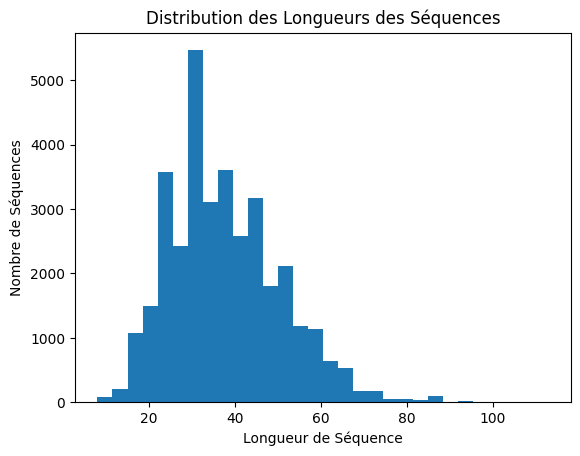

In [42]:
############ affichage longueur  max "balanced categorical feature"
seq_lenght = seq_l


mean_length = np.mean(seq_lenght)
max_length = np.max(seq_lenght)
min_length = np.min(seq_lenght)
std_dev = np.std(seq_lenght)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(seq_lenght, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [43]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 81927


In [44]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length   # je donne la taille max parmi les longueur des sequences
embedding_dim = 128  ## sa dimension ne doit pas depasser la valeur du [d_model dans l'encodeur]

In [45]:
####### NE PLUS EXECUTER  J'AI ENLEVER  LE GAP(GLOBAL E=AVERAGE POOLING CAR COMPLEXIFIE LE MODEL ##########


from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout, Flatten
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam, RMSprop,SGD

# Entrées

############## Balanced Model ####################

input_num = Input(shape=(taille_num_features,))
input_text = Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = Dense(256, activation='relu')(input_num)
num_branch = Dense(128, activation='relu')(num_branch)

# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text)


out_seq = Encodeur(
            n_layers=5,
            d_model=128,
            num_heads=2,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = Dropout(0.2)(out_seq)

# Fusion des branches

flattened_text_branch = Flatten()(text_branch) # je remodelise les dimension
merged = concatenate([num_branch, flattened_text_branch])

# Couches supplémentaires après la fusion
merged = Dropout(0.2)(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dense(32, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged)

# Création et compilation du modèle

model = Model(inputs=[input_num, input_text], outputs=output)
# opt = Adam(learning_rate=0.001)

# from tensorflow.keras.optimizers import RMSprop

# Création et compilation du modèle avec RMSprop
opt = RMSprop(learning_rate=0.001)  
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 113)]        0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 256)          2304        ['input_3[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 113, 128)     10486656    ['input_4[0][0]']                
                                                                                            

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Entrées pour l'entraînement
data_num = scaled_df
data_text = pad_sequences(tokens, maxlen=max_sequence_length,padding='post')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encodage de la cible en labels numériques
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

print(y_encoded.shape)
print("Classes encodées:", y_encoded)
print("Classes d'origine associées aux classes encodées:", label_encoder.classes_)

# print(y) [o=bengnin ,1=malicioux]


(34787,)
Classes encodées: [0 0 1 ... 1 1 1]
Classes d'origine associées aux classes encodées: ['Benin' 'malicieux']


In [47]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
# 80% pour l'entraînement et 20% pour le test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.15, random_state=42
)

# Maintenant, diviser l'ensemble d'entraînement en ensembles d'entraînement et de validation
# 80% pour l'entraînement et 10% pour la validation

text_train, text_val, num_train, num_val, labels_train, labels_val = train_test_split(
    text_train, num_train, labels_train, test_size=0.10/0.85, random_state=42
)


In [48]:
print(text_train.shape)
print(num_train.shape)
print(text_val.shape)
print(num_val.shape)
print(text_test.shape)
print(num_test.shape)


(26089, 113)
(26089, 8)
(3479, 113)
(3479, 8)
(5219, 113)
(5219, 8)


In [79]:
##### Ne pas executer  Quand je fais les test  car trop lent ####



import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

taille_num_features = taille_num_features  # Ajuster selon les données
taille_text_features = taille_text_features  # Ajuster selon les données
vocab_size = vocab_size  # Ajuster selon les données
    

def build_model(hp):
    
    input_num = Input(shape=(taille_num_features,))
    input_text = Input(shape=(taille_text_features,))

    # Branche numérique - FFN
    num_branch = Dense(units=hp.Int('num_units_1', min_value=64, max_value=512, step=64), activation='relu')(input_num)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(rate=hp.Float('num_dropout_1', min_value=0.1, max_value=0.5, step=0.1))(num_branch)
    num_branch = Dense(units=hp.Int('num_units_2', min_value=64, max_value=256, step=64), activation='relu')(num_branch)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(rate=hp.Float('num_dropout_2', min_value=0.1, max_value=0.5, step=0.1))(num_branch)

    # Branche textuelle - Embedding + Transformer
    embedding_dim = hp.Choice('embedding_dim', values=[128, 256, 512])
    text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)
    mask_inputs = masque_remplissage(input_text)
    out_seq = Encodeur(
                n_layers=hp.Int('n_layers', 1, 6, step=1),
                d_model=embedding_dim,
                num_heads=hp.Choice('num_heads', values=[4, 8, 16]),
                middle_units=hp.Int('middle_units', 128, 512, step=128),
                max_seq_len=taille_text_features)([text_branch, mask_inputs])
    out_seq = GlobalAveragePooling1D()(out_seq)
    out_seq = Dropout(rate=hp.Float('transformer_dropout', 0.1, 0.5, step=0.1))(out_seq)

    # Fusion des branches
    merged = concatenate([num_branch, out_seq])

    # Couches supplémentaires après la fusion
    merged = Dense(units=hp.Int('merged_units_1', 64, 256, step=64), activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate=hp.Float('merged_dropout_1', 0.1, 0.5, step=0.1))(merged)
    merged = Dense(units=hp.Int('merged_units_2', 32, 128, step=32), activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate=hp.Float('merged_dropout_2', 0.1, 0.5, step=0.1))(merged)
    merged = Dense(32, activation='relu')(merged)

    output = Dense(4, activation='softmax')(merged)

    model = Model(inputs=[input_num, input_text], outputs=output)

    opt = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Définir la recherche d'hyperparamètres
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='text_numerical_model_tuning'
)


# text_train, text_val, num_train, num_val, labels_train, labels_val = train_test_split(
#     text_train, num_train, labels_train, test_size=0.1, random_state=42
# )

# Préparer les données pour le tuner
train_data = [num_train, text_train]
val_data = [num_val, text_val]

# Lancer la recherche d'hyperparamètres
tuner.search(train_data, labels_train, epochs=10, validation_data=(val_data, labels_val), batch_size=32)

# Résumé des résultats
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Les meilleurs hyperparamètres sont :
- embedding_dim : {best_hps.get('embedding_dim')}
- num_units_1 : {best_hps.get('num_units_1')}
- num_dropout_1 : {best_hps.get('num_dropout_1')}
- num_units_2 : {best_hps.get('num_units_2')}
- num_dropout_2 : {best_hps.get('num_dropout_2')}
- n_layers : {best_hps.get('n_layers')}
- num_heads : {best_hps.get('num_heads')}
- middle_units : {best_hps.get('middle_units')}
- transformer_dropout : {best_hps.get('transformer_dropout')}
- merged_units_1 : {best_hps.get('merged_units_1')}
- merged_dropout_1 : {best_hps.get('merged_dropout_1')}
- merged_units_2 : {best_hps.get('merged_units_2')}
- merged_dropout_2 : {best_hps.get('merged_dropout_2')}
- learning_rate : {best_hps.get('learning_rate')}
""")


Trial 1 Complete [01h 58m 29s]
val_accuracy: 0.6385828852653503

Best val_accuracy So Far: 0.6385828852653503
Total elapsed time: 01h 58m 29s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
192               |448               |num_units_1
0.3               |0.5               |num_dropout_1
256               |192               |num_units_2
0.1               |0.1               |num_dropout_2
512               |256               |embedding_dim
4                 |6                 |n_layers
8                 |16                |num_heads
128               |256               |middle_units
0.2               |0.4               |transformer_dropout
128               |64                |merged_units_1
0.5               |0.5               |merged_dropout_1
128               |32                |merged_units_2
0.5               |0.1               |merged_dropout_2
0.0002635         |0.0010415         |learning_rate
2                 |2                 |tuner/epochs

In [49]:
history = model.fit(
    [num_train, text_train],  
    labels_train,            
    epochs=15,                
    batch_size=64,           
    validation_data=([num_val, text_val], labels_val) 
    
)


Train on 26089 samples, validate on 3479 samples
Epoch 1/15
26089/26089 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.8970

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


26089/26089 [==============================] - 128s 5ms/sample - loss: 0.2379 - accuracy: 0.8970 - val_loss: 0.1475 - val_accuracy: 0.9396
Epoch 2/15
26089/26089 [==============================] - 121s 5ms/sample - loss: 0.1255 - accuracy: 0.9496 - val_loss: 0.1085 - val_accuracy: 0.9531
Epoch 3/15
26089/26089 [==============================] - 120s 5ms/sample - loss: 0.0858 - accuracy: 0.9664 - val_loss: 0.1050 - val_accuracy: 0.9580
Epoch 4/15
26089/26089 [==============================] - 120s 5ms/sample - loss: 0.0588 - accuracy: 0.9773 - val_loss: 0.1008 - val_accuracy: 0.9664
Epoch 5/15
26089/26089 [==============================] - 121s 5ms/sample - loss: 0.0407 - accuracy: 0.9848 - val_loss: 0.1125 - val_accuracy: 0.9635
Epoch 6/15
26089/26089 [==============================] - 120s 5ms/sample - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.1328 - val_accuracy: 0.9672
Epoch 7/15
26089/26089 [==============================] - 119s 5ms/sample - loss: 0.0224 - accuracy: 0.9922 - v

In [50]:
#on effectue les prediction sur les donnees de test

y_pred = model.predict([num_test,text_test])

# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner par la fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

### Evaluation

evaluation_results = model.evaluate([num_test,text_test], labels_test)

# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Balanced Perte sur les données de test:", evaluation_results[0])
print("Balanced Précision sur les données de test:", evaluation_results[1])


c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Balanced Perte sur les données de test: 0.18677347253816215
Balanced Précision sur les données de test: 0.969726


In [51]:
from sklearn.metrics import classification_report,accuracy_score


# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred)
print("Balanced Rapport de classification :\n", class_report)


Balanced Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      1806
           1       0.98      0.98      0.98      3413

    accuracy                           0.97      5219
   macro avg       0.97      0.97      0.97      5219
weighted avg       0.97      0.97      0.97      5219



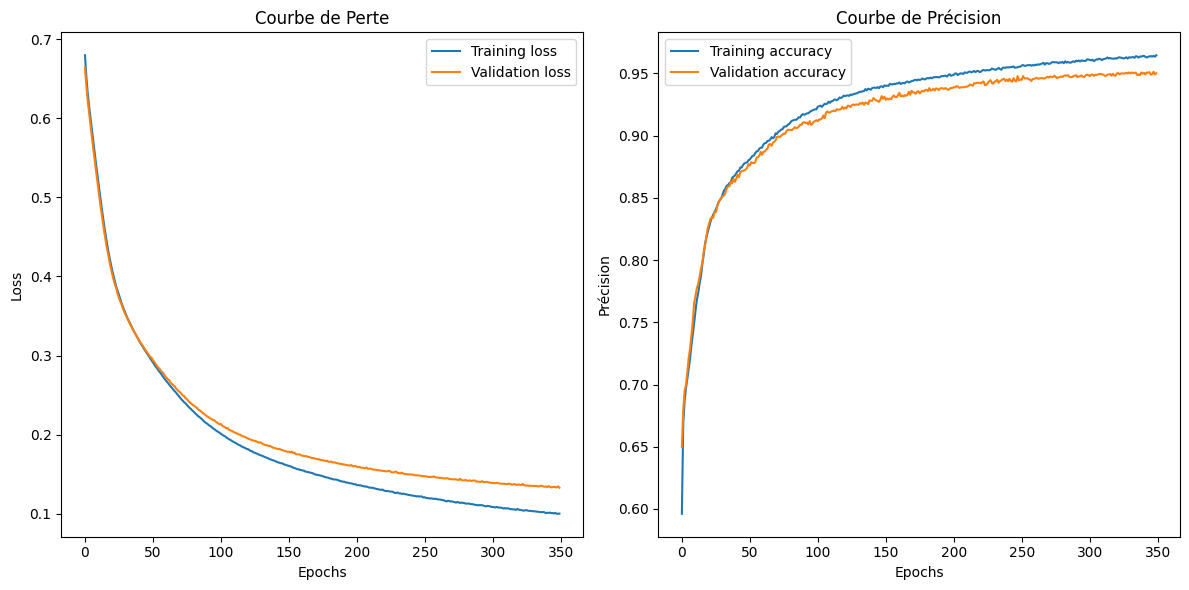

In [29]:
# ########## Pour l'encodeur sur 350 Epochs ########

# import matplotlib.pyplot as plt


# # Extraction des métriques d'entraînement
# loss = history.history['loss']
# accuracy = history.history['accuracy']
# val_loss = history.history['val_loss']
# val_accuracy = history.history['val_accuracy']

# # Affichage des courbes de perte et d'exactitude séparément
# epochs = range(1, len(loss) + 1)

# # Affichage des courbes d'apprentissage et de validation
# plt.figure(figsize=(12, 6))

# # Plot de la perte d'entraînement et de la perte de validation
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Courbe de Perte')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()


# # Plot de la précision d'entraînement et de la précision de validation
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# plt.title('Courbe de Précision')
# plt.xlabel('Epochs')
# plt.ylabel('Précision')
# plt.legend()

# # Afficher les deux sous-plots
# plt.tight_layout()
# plt.show()

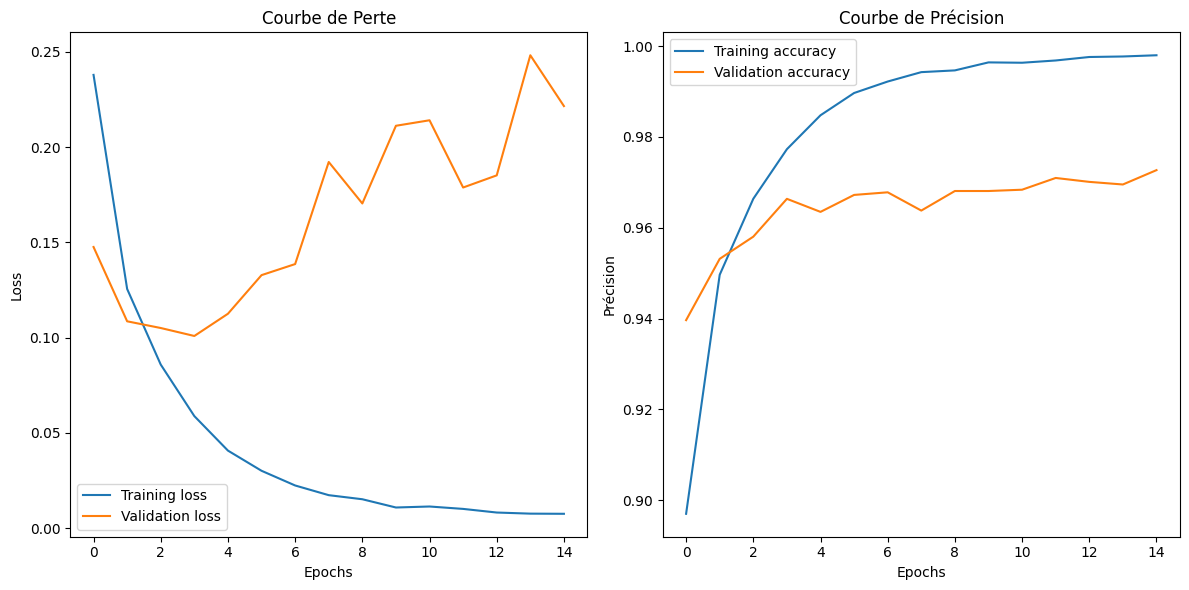

In [52]:
########## Pour le CNN sur 30 Epochs ########

import matplotlib.pyplot as plt


# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

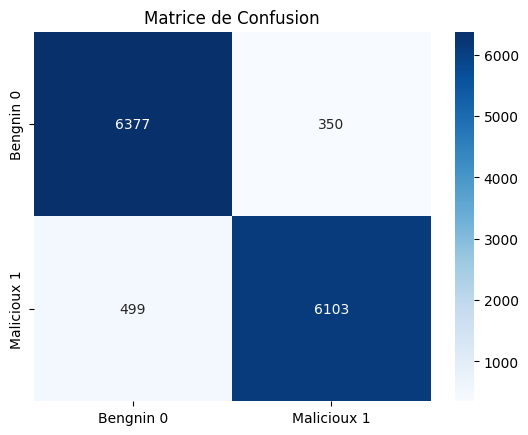

In [25]:
#### Balanced #######


#affichage de la matrixe de confusion

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(labels_test,y_pred)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()

# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Bengnin 0', 'Malicioux 1'], columns=['Bengnin 0', 'Malicioux 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


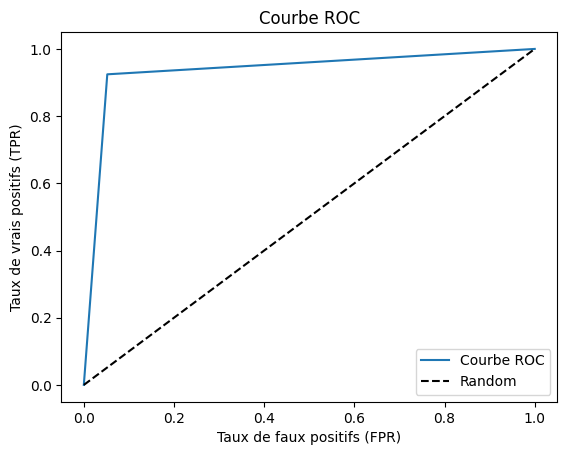

Aire sous la courbe (AUC) : 0.9361938535322283


In [26]:
#Courbe de ROC

from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(labels_test, y_pred)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(labels_test, y_pred)
print('Aire sous la courbe (AUC) :', auc)
